# Python ile Veri analizi ve Veri Mühendisliği

### Tanım
Bu Çalışmada örnek bir ETL yani extract, transform and load çalışmasını yapacağız. 
Çalışmamızda kullanacağımız analiz yöntemi ise Covid-19 un vakalar üstündeki etkisi olacak. Bu çalışmada 2 tane ülkeyi karşılaştıracağız bu ülkeler Türkiye ve İngiltere olacak. Her iki ülkede de farklı aşılar kullandığından dolay aşıları ne kadar etkin olduğunu da görme şansımız olacak.
Bu çalışmada data pipeline ları yaratmak, MySql ile table yaratmak, Pandas ve Sqlalchemy kullanarak bunları kaydetmeyi öğreneceğiz.

Çalışmayı iki parçaya ayırdım, birinci kısımda veri analizi yapacağız ikinci kısımda ise basit bir şekilde veri mühendisliği yapacağız.

### Hazırlık
1 - bütün data ları çekmek:

Kullanacağızım verileri, her gün düzenli olarak güncellenen https://ourworldindata.org/ sitesinin https://github.com/owid github hesabından alacağız, böylece her zaman güncel data lara erişim sağlayabileceğiz.

2 - Üstünde çalışacağımız ülkeleri filtrelemek

Sadece Türkiye ve İngiltere ile çalışacağız ancak bu notebook u indirip istediğiniz ülkeler üstünden de çalışabilirsiniz.

3 - data ları birleştirip daha iyi bir görüntü elde etmek

Vaka, test, aşılama ve mobilite verilerini tarih üstünden birleştireceğiz böylece tek dataframe de çalışabileceğiz.

4 - veri görselleştirme ile trendleri gözlemlemek

Bazı önemli sayıları görselleştirip karşılaştırmalar yapacağız.

5 - gerekli tabloları yaratacak ve datayı kaydedecek fonksiyonlar

6 - flask ile api yi oluşturmak

## Veri Analizi

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
pd.options.display.max_columns = None

In [137]:
df_cases=pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
df_mobility=pd.read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv")

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [139]:
#çalışacağımız ülkelerin listesi
country_list=['Turkey',  'United Kingdom']

#date type düzeltilmeli öncelikle çünkü object olarak geliyor
df_cases['date']=pd.to_datetime(df_cases['date'])
df_mobility['date']=pd.to_datetime(df_mobility['date'])

# mobility datasını çekme ve düzenleme
df_mobility2=df_mobility.loc[df_mobility['country_region'].isin(country_list)].loc[df_mobility['sub_region_1'].isna()].fillna(0)
df_mobility2=df_mobility2.loc[df_mobility2['date']>='2021-01-03']
df_mobility2['location']=df_mobility2['country_region']

#vaka datasını çekme ve düzeltme
df_cases2=df_cases.loc[df_cases.location.isin(country_list)].fillna(0)
df_cases2=df_cases2.loc[df_cases2['date']>='2021-01-03']


In [140]:
#ülke ve tarihe göre sıralama, bu sayede merge işlemi de daha basit olacak.
df_cases2.sort_values(by=['location', 'date'])
df_mobility2.sort_values(by=['location', 'date'])

df_merged=df_cases2.merge(df_mobility2, on=['location', 'date'], how='left')
df_merged.tail(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
245,GBR,Europe,United Kingdom,2021-05-03,4437505.0,1674.0,2134.714,127797.0,1.0,15.571,65367.008,24.659,31.446,1882.524,0.015,0.229,0.86,187.0,2.755,1297.0,19.106,0.0,0.0,0.0,0.0,1069724.0,156093792.0,2299.352,15.758,971705.0,14.314,0.002,455.2,tests performed,50297911.0,34667904.0,15630007.0,200099.0,464646.0,74.09,51.07,23.02,6845.0,59.72,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,0.0,2.54,81.32,0.932,GB,United Kingdom,0.0,0.0,0.0,0.0,0.0,ChIJqZHHQhE7WgIReiWIMkOg-MQ,-29.0,-11.0,30.0,-58.0,-73.0,21.0
246,GBR,Europe,United Kingdom,2021-05-04,4439489.0,1984.0,2032.857,127803.0,6.0,14.000,65396.234,29.225,29.945,1882.612,0.088,0.206,0.88,181.0,2.666,1289.0,18.988,0.0,0.0,0.0,0.0,860368.0,157088742.0,2314.008,12.674,998197.0,14.704,0.002,491.0,tests performed,50682567.0,34795074.0,15887493.0,384656.0,448798.0,74.66,51.26,23.40,6611.0,59.72,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,0.0,2.54,81.32,0.932,GB,United Kingdom,0.0,0.0,0.0,0.0,0.0,ChIJqZHHQhE7WgIReiWIMkOg-MQ,-31.0,3.0,19.0,-41.0,-34.0,11.0
247,GBR,Europe,United Kingdom,2021-05-05,4441644.0,2155.0,2036.286,127830.0,27.0,13.714,65427.978,31.744,29.996,1883.010,0.398,0.202,0.90,182.0,2.681,0.0,0.000,0.0,0.0,0.0,0.0,1214689.0,158363333.0,2332.783,17.893,978101.0,14.408,0.002,480.3,tests performed,51225890.0,34934171.0,16291719.0,543323.0,441126.0,75.46,51.46,24.00,6498.0,59.72,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,0.0,2.54,81.32,0.932,GB,United Kingdom,0.0,0.0,0.0,0.0,0.0,ChIJqZHHQhE7WgIReiWIMkOg-MQ,-29.0,2.0,30.0,-40.0,-32.0,11.0
248,GBR,Europe,United Kingdom,2021-05-06,4444262.0,2618.0,2059.000,127843.0,13.0,12.000,65466.543,38.565,30.330,1883.201,0.191,0.177,0.00,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0,51834361.0,35069641.0,16764720.0,608471.0,440317.0,76.36,51.66,24.70,6486.0,59.72,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,0.0,2.54,81.32,0.932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249,GBR,Europe,United Kingdom,2021-05-07,4446752.0,2490.0,2072.286,127858.0,15.0,11.857,65503.222,36.679,30.526,1883.422,0.221,0.175,0.00,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,59.72,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,0.0,2.54,81.32,0.932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

#### Hareketlilik data sını kullanarak aslında ne tür bir karantina uygulaması var anlaşılabilir.

<AxesSubplot:title={'center':'Türkiye Hareketlilik Ofis-Ev-Marketler'}, xlabel='date'>

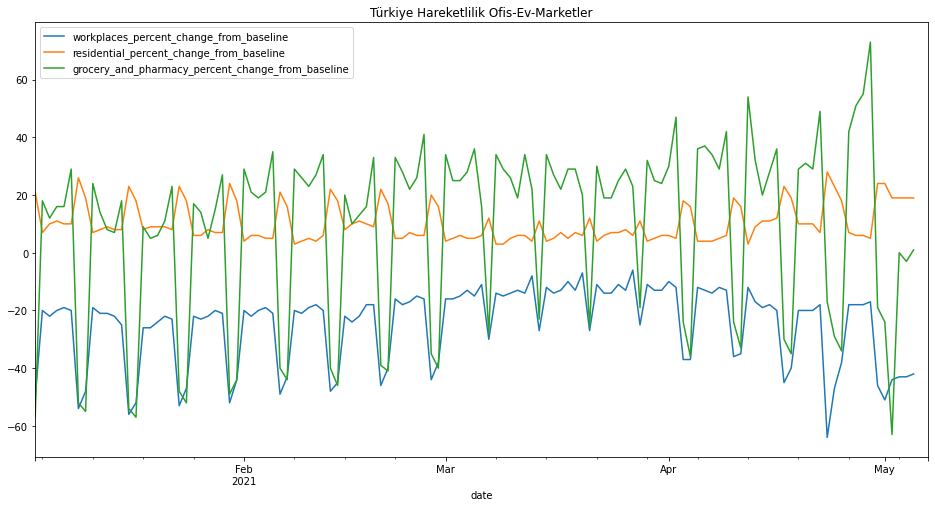

In [141]:
df_merged[df_merged['iso_code']=='TUR'].set_index('date')[['workplaces_percent_change_from_baseline', 
                                                           'residential_percent_change_from_baseline',
                                                           'grocery_and_pharmacy_percent_change_from_baseline']].plot(figsize=(16,8), title="Türkiye Hareketlilik Ofis-Ev-Marketler")                                                

<AxesSubplot:title={'center':'İngiltere Hareketlilik Ofis-Ev-Marketler'}, xlabel='date'>

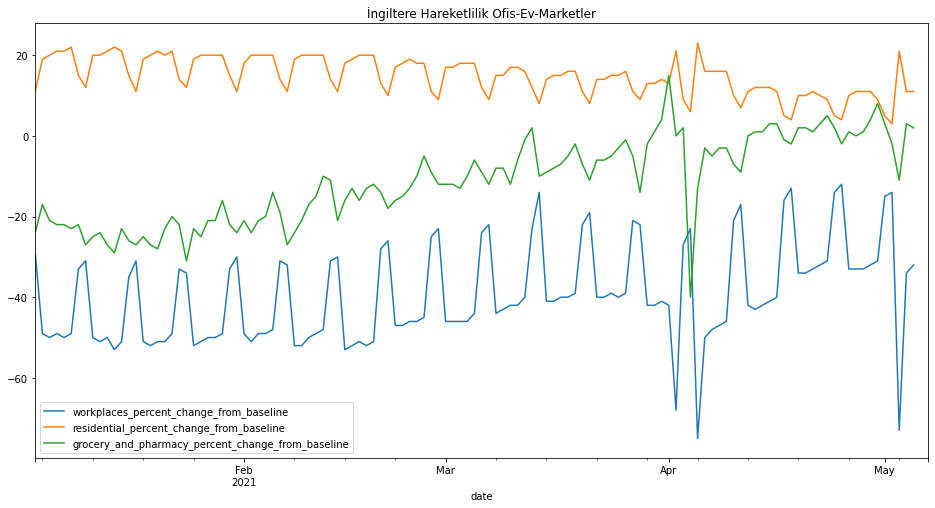

In [142]:
df_merged[df_merged['iso_code']=='GBR'].set_index('date')[['workplaces_percent_change_from_baseline', 
                                                           'residential_percent_change_from_baseline', 
                                                           'grocery_and_pharmacy_percent_change_from_baseline']].plot(figsize=(16,8), title="İngiltere Hareketlilik Ofis-Ev-Marketler")                                                     

#### reproduction rate ülke karşılaştırması
Türkiye şubat sonrası artan vakaların bir açıklaması olabilir, kısıtlamaların artması bu oranı düşürmüş olmakta.

<AxesSubplot:title={'center':'Reproduction Rate'}, xlabel='date'>

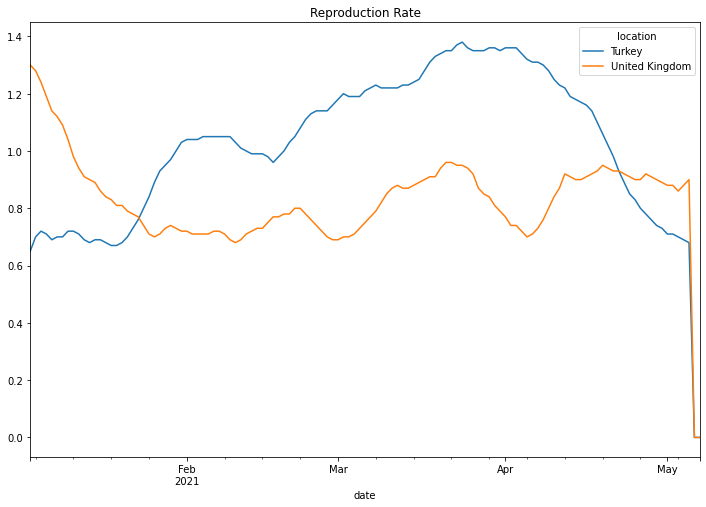

In [143]:
df_merged.set_index(['date', 'location'], drop=True)['reproduction_rate'].unstack('location').reset_index().set_index('date').plot(figsize=(12,8), title="Reproduction Rate")

<AxesSubplot:title={'center':'Yeni Vaka Sayısı'}, xlabel='date'>

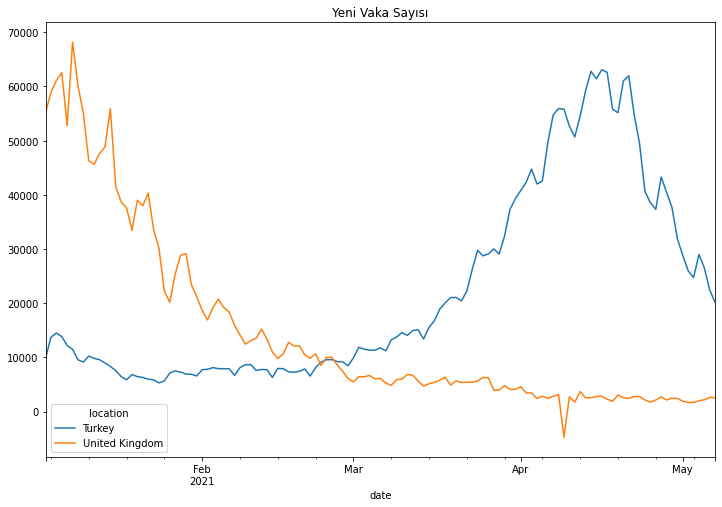

In [144]:
df_merged.set_index(['date', 'location'], drop=True)['new_cases'].unstack('location').reset_index().set_index('date').plot(figsize=(12,8), title="Yeni Vaka Sayısı")

#### pozitif vaka oranlarının iki ülkede değişimi

<AxesSubplot:title={'center':'Pozitif Oranı'}, xlabel='date'>

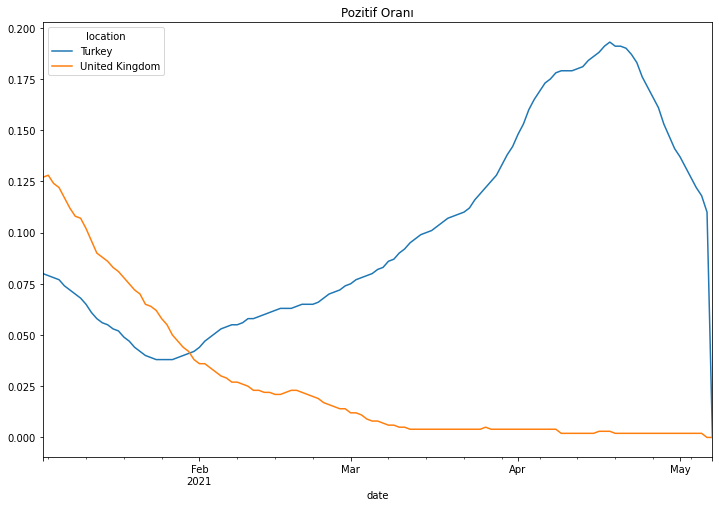

In [145]:
df_merged.set_index(['date', 'location'], drop=True)['positive_rate'].unstack('location').reset_index().set_index('date').plot(figsize=(12,8), title="Pozitif Oranı")

#### Toplam aşılama sayısı karşılaştırması

<AxesSubplot:title={'center':'Aşılanan Kişi Sayısı'}, xlabel='date'>

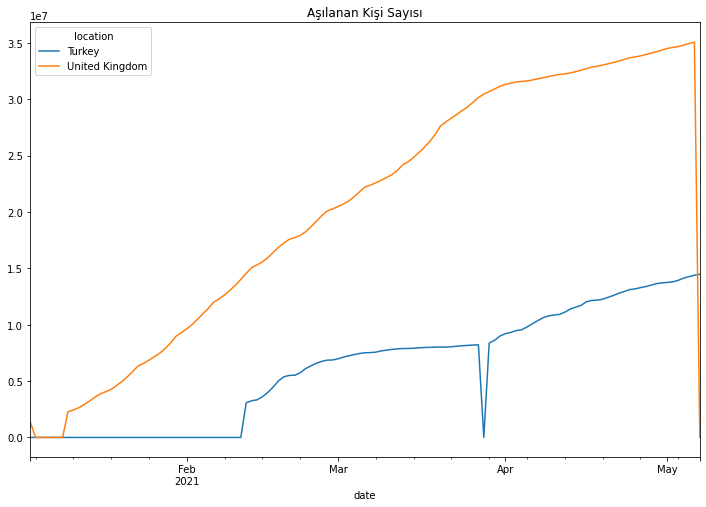

In [146]:
df_merged.set_index(['date', 'location'], drop=True)['people_vaccinated'].unstack('location').reset_index().set_index('date').plot(figsize=(12,8), title="Aşılanan Kişi Sayısı")

#### günlük aşılanan sayısı

<AxesSubplot:title={'center':'Milyonda Yeni Aşılanan Sayısı'}, xlabel='date'>

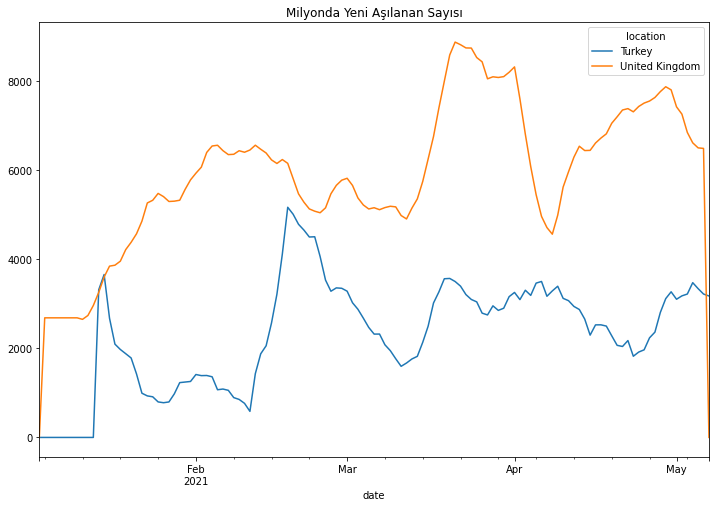

In [147]:
df_merged.set_index(['date', 'location'], drop=True)['new_vaccinations_smoothed_per_million'].unstack('location').reset_index().set_index('date').plot(figsize=(12,8), title="Milyonda Yeni Aşılanan Sayısı")

## Veri Mühendisliği

Şimdi çok basit bir düzeyde veri mühendisliği yapacağız, 
Yukarıda bazı analizler yaptım ancak benim ayrıca merak ettiğim hareket verisi ile yeni vakalar ve R değeri arasında nasıl bir ilişik var.
Bunu basitçe df_merged.corr() ile bulabilirim tabi ama ayrıca farklı bir çalışma yapıp bu korelasyon değerlerinin zamanla nasıl değiştiğini de 
merak ediyorum bunu sağlamanın yolu ise her gün korelasyonu hesaplayıp bir database e kaydetmek olabilir.

Aşağıda belirttiğim sütunların değerlerini almak istiyorum öncelikle sonrasında ise her iki ülke için korelasyon değerini hesaplayıp yeni bir dataframe yaratıp 
bunları birleştireceğim ve df_final dediğim dataframe i elde edeceğim.

Belirtilen sütunlar arasındaki korelasyon değişimi vaka artış ve azalışlarında mobilite olarak neyin etkili olduğunu anlamamıza yardımcı olacak,
mesela artan vakalar ile birlikte vaka ve residential_percent_change_from_baseline arasındaki korelasyon da artıyorsa burada bu mobilite verisinin veri artışı ile alakalı olduğunu söyleyebileceğiz.

In [148]:
cols=['new_cases', 
      'positive_rate', 
      'total_vaccinations',
      'reproduction_rate',
      'grocery_and_pharmacy_percent_change_from_baseline', 
      'parks_percent_change_from_baseline', 
      'transit_stations_percent_change_from_baseline', 
      'workplaces_percent_change_from_baseline',
      'residential_percent_change_from_baseline',
      'retail_and_recreation_percent_change_from_baseline']

In [149]:
df_merged_tr=df_merged.loc[df_merged['iso_code']=='TUR'][cols].corr()[['new_cases', 'reproduction_rate']].reset_index()
df_merged_tr.columns=['corr_indicator', 'new_cases_corr_tr', 'reproduction_rate_corr_tr']
df_merged_uk=df_merged.loc[df_merged['iso_code']=='GBR'][cols].corr()[['new_cases', 'reproduction_rate']].reset_index()
df_merged_uk.columns=['corr_indicator', 'new_cases_corr_uk', 'reproduction_rate_corr_uk']
df_final=df_merged_uk.merge(df_merged_tr, on='corr_indicator')
df_final['update_date']=dt.date.today()
df_final

,corr_indicator,new_cases_corr_uk,reproduction_rate_corr_uk,new_cases_corr_tr,reproduction_rate_corr_tr,update_date
0,new_cases,1.000000,0.381198,1.000000,0.286125,2021-05-09
1,positive_rate,0.985586,0.384753,0.957195,0.356533,2021-05-09
2,total_vaccinations,-0.798349,0.002168,0.802416,0.167403,2021-05-09
3,reproduction_rate,0.381198,1.000000,0.286125,1.000000,2021-05-09
4,grocery_and_pharmacy_percent_change_from_baseline,-0.706362,0.103126,0.202625,0.267518,2021-05-09
5,parks_percent_change_from_baseline,-0.636341,0.062016,0.190150,0.302113,2021-05-09
6,transit_stations_percent_change_from_baseline,-0.629192,0.241087,0.118360,0.334467,2021-05-09
7,workplaces_percent_change_from_baseline,-0.292354,0.182641,0.104674,0.484308,2021-05-09
8,residential_percent_change_from_baseline,0.481170,-0.168703,0.054059,-0.385386,2021-05-09
9,retail_and_recreation_percent_change_from_base...,-0.604830,0.197788,0.117164,0.351014,2021-05-09


### Database oluşturma ve veriyi kaydetme

Burada Pandas ve Sqlalchemy kullarak nasit bir şekilde bir table oluşturacağız sonrasında ise yukarıda oluşturduğumuz dataframe i bu table e kaydedeceğiz.
Bu aşağıdaki kodları her gün çalıştırdığımızda verilerimiz günlük olarak birikmiş olacak.

In [129]:
#Mysql database e bağlantı fonksiyonlar
def mysql_connection():
    user = ''
    password = ''
    host = ''
    port = ''
    database = ''
    engine = create_engine("mysql://{0}:{1}@{2}:{3}/{4}".format(user, password, host, port, database), encoding='utf8')
    return engine

def mysql_conn(engine):
    conn = engine.raw_connection()
    return conn
#Tabloyu oluşturma fonksiyonu
def make_table(conn, query):
    cur = conn.cursor()
    cur.execute(query)
    cur.close()
    conn.commit()
"""
Aşağıda table yaratmak için gerekli query i yazıyoruz, öncelikle id isimli bir sütun oluşturacağız ve her veri eklendiğinde id otomatik oluşacak.
Diğer verilerin sütunlarını oluştururken onların veri türlerine uygun olmasın dikkat etmeliyiz ayrıca bunu ilk tabloyu oluşturduğunuzda sadece bir defa 
çalıştırmalısınız ve tablo oluşacaktır.
"""

create_table_query="""
CREATE TABLE
  covid_corr_change ( 
     id INT(6) UNSIGNED AUTO_INCREMENT PRIMARY KEY,
    `corr_indicator` TEXT NOT NULL,
    `new_cases_corr_uk` FLOAT NOT NULL,
    `reproduction_rate_corr_uk` FLOAT NOT NULL,
    `new_cases_corr_tr` FLOAT NOT NULL,
    `reproduction_rate_corr_tr` FLOAT NOT NULL,
    `update_date` date NOT NULL)
"""


make_table(mysql_conn(mysql_connection()), create_table_query) #bunu sadece ilk kez tabloyu oluşturduğunuzda kullanın.
def upsert_it():
    return df_final.to_sql('covid_corr_change', mysql_connection(), if_exists='replace')# tabloyu oluşturduktan sonra replace kısmını append ile değiştiriniz
upsert_it()

Yukarıdaki kodu günlük olarak çalıştırmak için cronjob kurmak bir sonraki aşama olabilir böylece bütun bu notebook günlük olarak çalışır
ve siz de kaydettiğiniz verileriniz üstünden istediğiniz analizleri yapabilirsiniz.